#  Computational Performance of the Project Crashing Problem

In [1]:
import numpy as np
import pandas as pd
import rsome as rso
from rsome import ro
from rsome import grb_solver as grb

In [2]:
import matplotlib.pyplot as plt
import matplotlib

rc = {"mathtext.fontset": "cm",
      "text.latex.preamble": r"\usepackage{amsmath}"}
matplotlib.rc('text', usetex=False)
plt.rcParams.update(rc)
plt.rcParams['font.family'] = 'Times New Roman'

nusblue = [0/255, 66/255, 130/255]
nusorange = [239/255, 124/255, 1/255]

fs = 15   # label font size
fl = 14   # legend font size
ft = 12   # tick font size

In [3]:
def network(row, col):
    """
    The function network creates a project crashing network and
    return the node (pos) and edge (edges) information.
    """
    
    xdata, ydata = np.meshgrid(range(col), range(row))
    nodes = pd.Series(range(xdata.size), 
                      index=[(x, y) for x, y in zip(xdata.flatten(), ydata.flatten())])
    
    edges_dict = {'from': [], 'to': []}
    for i in range(col):
        for j in range(row):
            if i + 1 < col:
                edges_dict['from'].append(nodes[i, j])
                edges_dict['to'].append(nodes[i+1, j])
            
        
            if j + 1 < row:
                edges_dict['from'].append(nodes[i, j])
                edges_dict['to'].append(nodes[i, j+1])

    np.random.seed(0)
    edges = pd.DataFrame(edges_dict, dtype=int)

    pos = nodes.index.values
    
    return pos, edges

### Function for the Deterministic Model

In [4]:
def det_proma(b, c, target, zhat):
    """
    The function det_proma() solves the deterministic project
    management problem.
    
    Parameters
    ----------
    b : float or np.ndarray
        The upper bound of the here-and-now decision x
    c : np.ndarray
        The cost coefficient of each node
    target : float
        The target value for the total completion time.
    zhat : np.ndarray
        The predicted values of the random variable z
        
    Returns
    -------
    xs : np.ndarray
        The optimal solution for the decision variable x.
    cost : float
        The optimal objective value in terms of the total cost.
    solution : rsome.lp.Solution
        The solution information of the model
    """
    
    model = ro.Model()

    I = len(c)
    x = model.dvar(I)
    y = model.dvar(I + 1)

    model.min(c@x)
    model.st(x >= 0, x <= b)
    model.st(y[-1] <= target)
    model.st(y >= 0)

    idx_i = edges['from'].values
    idx_j = edges['to'].values
    model.st(y[idx_j] - y[idx_i] >= zhat[idx_i]*(1-x[idx_i]))
    model.st(y[I] - y[I-1] >= zhat[I-1]*(1-x[I-1]))

    model.solve(grb, display=False, params={'TimeLimit': 1200})
    
    return x.get(), model.get(), model.solution

### Function for the Robust Satisficing Model

In [5]:
def rs_proma(b, c, target, zhat, v, gamma, Dmat, delta=None):
    """
    The function rs_proma() solves the project management problem
    formulated as a robust satisficing model with one-norm support.
    
    Parameters
    ----------
    b : float or np.ndarray
        The upper bound of the here-and-now decision x
    c : np.ndarray
        The cost coefficient of each node
    target : float
        The target value for the total completion time.
    zhat : np.ndarray
        The predicted values of the random variable z
    v : float
        The total cost of the corresponding determnistic problem.
    gamma : float
        The extra budget.
    Dmat : np.ndarray
        A two-dimensional array representing the transformation of
        random variables
    delta : float
        The one-norm support coefficient delta. If delta is None, 
        the support is unbounded, i.e. delta -> infinity.
        
    Returns
    -------
    xs : np.ndarray
        The optimal solution for the decision variable x.
    cost : float
        The optimal objective in terms of the kappa value.
    solution : rsome.lp.Solution
        The solution information of the model
    """
    
    model = ro.Model()

    I = len(c)
    x = model.dvar(I)
    kappa = model.dvar()
    
    z = model.rvar(I)
    r = model.rvar(I)
    s = model.rvar(I)
    u = model.rvar()
    if delta is None:
        uset = (z == Dmat@(r - s) + zhat, (r + s).sum() <= u,
                r >= 0, s >= 0)
    else:
        uset = (z == Dmat@(r - s) + zhat, (r + s).sum() <= u,
                u <= delta, r >= 0, s >= 0)

    y = model.ldr(I + 1)
    y.adapt(r)
    y.adapt(s)
    

    model.minmax(kappa, uset)
    model.st(kappa >= 0)
    model.st(c@x <= v + gamma)
    model.st(x >= 0, x <= b)
    model.st(y[-1] - u*kappa <= target)
    model.st(y >= 0)

    idx_i = edges['from'].values
    idx_j = edges['to'].values
    model.st(y[idx_j] - y[idx_i] >= z[idx_i]*(1-x[idx_i]))
    model.st(y[I] - y[I-1] >= z[I-1]*(1-x[I-1]))

    model.solve(grb, display=False)
    
    return x.get(), c@x(), model.solution

In [6]:
def rs_proma_or(b, c, target, zhat, v, gamma, Dmat, ub):
    """
    The function rs_proma_or() solves the project management
    problem formulated as a robust satisficing model with infimal
    convolution.
    
    Parameters
    ----------
    b : float or np.ndarray
        The upper bound of the here-and-now decision x
    c : np.ndarray
        The cost coefficient of each node
    target : float
        The target value for the total completion time.
    zhat : np.ndarray
        The predicted values of the random variable z
    v : float
        The total cost of the corresponding determnistic problem.
    gamma : float
        The extra budget.
    Dmat : np.ndarray
        A square matrix for the transformation of the random 
        variable z.
    ub : float or np.ndarray
        The upper bound of the random variable z
    delta : float
        The one-norm support coefficient delta. If delta is None, 
        the support is unbounded, i.e. delta -> infinity.
        
    Returns
    -------
    xs : np.ndarray
        The optimal solution for the decision variable x.
    cost : float
        The optimal objective in terms of the kappa value.
    solution : rsome.lp.Solution
        The solution information of the model
    """
    
    model = ro.Model()

    I = len(c)
    x = model.dvar(I)
    y = model.dvar(I + 1)
    kappa = model.dvar()
    
    xbar = model.dvar(I)
    ybar = model.dvar(I + 1)
    alpha = model.dvar()
    
    model.min(kappa)
    model.st(c@x <= v + gamma)
    model.st(ybar[-1] + y[-1] <= target)
    model.st(Dmat@(1 - alpha - (x - xbar)) <= kappa, 0 <= kappa)
    
    idx_i = edges['from'].values
    idx_j = edges['to'].values
    model.st(y[idx_j] - y[idx_i] >= zhat[idx_i]*(1 - alpha - (x[idx_i] - xbar[idx_i])))
    model.st(y[I] - y[I-1] >= zhat[I-1]*(1 - alpha - (x[I-1] - xbar[I-1])))
    model.st(ybar[idx_j] - ybar[idx_i] >= ub[idx_i]*(alpha - xbar[idx_i]))
    model.st(ybar[I] - ybar[I-1] >= ub[I-1]*(alpha - xbar[I-1]))
    
    model.st(xbar <= alpha, 0 <= alpha, alpha <= 1)
    model.st(0 <= x, x <= b, y >= 0, ybar >= 0)
    
    model.solve(grb, display=False)
    
    return x.get(), c@x(), model.solution

In [7]:
def rs_proma_box(b, c, target, zhat, v, gamma, Dmat, lb, ub, delta=None):
    """
    The function rs_proma_box() solves the project management
    problem formulated as a robust satisficing model with mixed
    one-norm and box support. 
    
    Parameters
    ----------
    b : float or np.ndarray
        The upper bound of the here-and-now decision x
    c : np.ndarray
        The cost coefficient of each node
    target : float
        The target value for the total completion time.
    zhat : np.ndarray
        The predicted values of the random variable z
    v : float
        The total cost of the corresponding determnistic problem.
    gamma : float
        The extra budget.
    Dmat : np.ndarray
        A square matrix for the transformation of the random 
        variable z.
    lb : float or np.ndarray
        The lower bound of the random variable z.
    ub : float or np.ndarray
        The upper bound of the random variable z.
    delta : float
        The one-norm support coefficient delta. If delta is None, 
        the support is unbounded, i.e. delta -> infinity.
        
    Returns
    -------
    xs : np.ndarray
        The optimal solution for the decision variable x.
    cost : float
        The optimal objective in terms of the kappa value.
    solution : rsome.lp.Solution
        The solution information of the model
    """
    
    model = ro.Model()

    I = len(c)
    x = model.dvar(I)
    kappa = model.dvar()
    
    z = model.rvar(I)
    r = model.rvar(I)
    s = model.rvar(I)
    u = model.rvar()
    
    if delta is None:
        uset = (z == Dmat@(r - s) + zhat, (r + s).sum() <= u, 
                z >= lb, z <= ub,
                r >= 0, s >= 0)
    else:
        uset = (z == Dmat@(r - s) + zhat, (r + s).sum() <= u, 
                z >= lb, z <= ub, u <= delta,
                r >= 0, s >= 0)
    
    y = model.ldr(I + 1)
    y.adapt(r)
    y.adapt(s)
    
    model.minmax(kappa, uset)
    model.st(kappa >= 0)
    model.st(c@x <= v + gamma)
    model.st(x >= 0, x <= b)
    model.st(y[-1] - u*kappa <= target)
    model.st(y >= 0)

    idx_i = edges['from'].values
    idx_j = edges['to'].values
    model.st(y[idx_j] - y[idx_i] >= z[idx_i]*(1-x[idx_i]))
    model.st(y[I] - y[I-1] >= z[I-1]*(1-x[I-1]))

    model.solve(grb, display=False)
    
    return x.get(), c@x(), model.solution

### Function for Generate Samples

In [8]:
def sample_gen(zhat, dev, size):
    """
    The function sample_gen generates random samples uniformly distributed
    within the range [zhat - dev, zhat + dev]. The sample size is specified
    by the argument size. 
    """
    
    n = len(zhat)
    
    return zhat + dev * (2*np.random.rand(size, n) - 1)

### Experiments on Computational Cost

In [9]:
row = 4
col = 5
b = 0.5

np.random.seed(20)
step = 3
nn = 8

rs_ic_time = np.ones(nn) * np.nan
rs_box_time = np.ones(nn) * np.nan
rs_delta_time = np.ones(nn) * np.nan
for i in range(nn):
    
    pos, edges = network(row, col)
    
    I = len(pos)
    zhat = 10 * np.ones(I)
    c = np.ones(I)
    
    target = (row + col - 1) * zhat.mean() * 0.75
    print(f'Experiement {i+1}: ({row}x{col})  target = {target}')
    
    Nin = 10*I
    np.random.seed(0)
    sigma = 6 * np.random.rand(I)
    zin = sample_gen(zhat, sigma, Nin)
    
    ub = zin.max(axis=0)
    lb = zin.min(axis=0)
    zmean = zin.mean(axis=0)
    dev = I * abs(zin - zmean).mean(axis=0)
    Dmat = np.diag(dev)
    delta = max(abs((zin - zin.mean(axis=0)) @ np.linalg.inv(Dmat)).sum(axis=1))
    
    x, obj, sol = det_proma(b, c, target, zhat)
    
    v = obj
    gamma = 1.0 * v
    
    _, _, sol = rs_proma(b, c, target, zhat, v, gamma, Dmat, delta)
    rs_delta_time[i] = sol.time
    print(f'One-Norm suport model finished.   Duration: {rs_delta_time[i]:.4f}')
    
    _, _, sol = rs_proma_or(b, c, target, zmean, v, gamma, Dmat, ub)
    rs_ic_time[i] = sol.time
    print(f'OR mixed support model finished.  Duration: {rs_ic_time[i]:.4f}')
    
    _, _, sol = rs_proma_box(b, c, target, zmean, v, gamma, Dmat, lb, ub)
    rs_box_time[i] = sol.time
    print(f'AR mixed support model finished.  Duration: {rs_box_time[i]:.4f}')
    
    
    print('---------------------------------------------------------------\n')
    
    row += step
    col += step

Experiement 1: (4x5)  target = 60.0
Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-11
One-Norm suport model finished.   Duration: 0.0132
OR mixed support model finished.  Duration: 0.0008
AR mixed support model finished.  Duration: 0.0373
---------------------------------------------------------------

Experiement 2: (7x8)  target = 105.0
One-Norm suport model finished.   Duration: 0.3791
OR mixed support model finished.  Duration: 0.0039
AR mixed support model finished.  Duration: 0.4047
---------------------------------------------------------------

Experiement 3: (10x11)  target = 150.0
One-Norm suport model finished.   Duration: 2.2741
OR mixed support model finished.  Duration: 0.0128
AR mixed support model finished.  Duration: 2.3467
---------------------------------------------------------------

Experiement 4: (13x14)  target = 195.0
One-Norm suport model finished.   Duration: 12.5106
OR mixed support model finished.  Duration: 0.0295
A

### Visualization

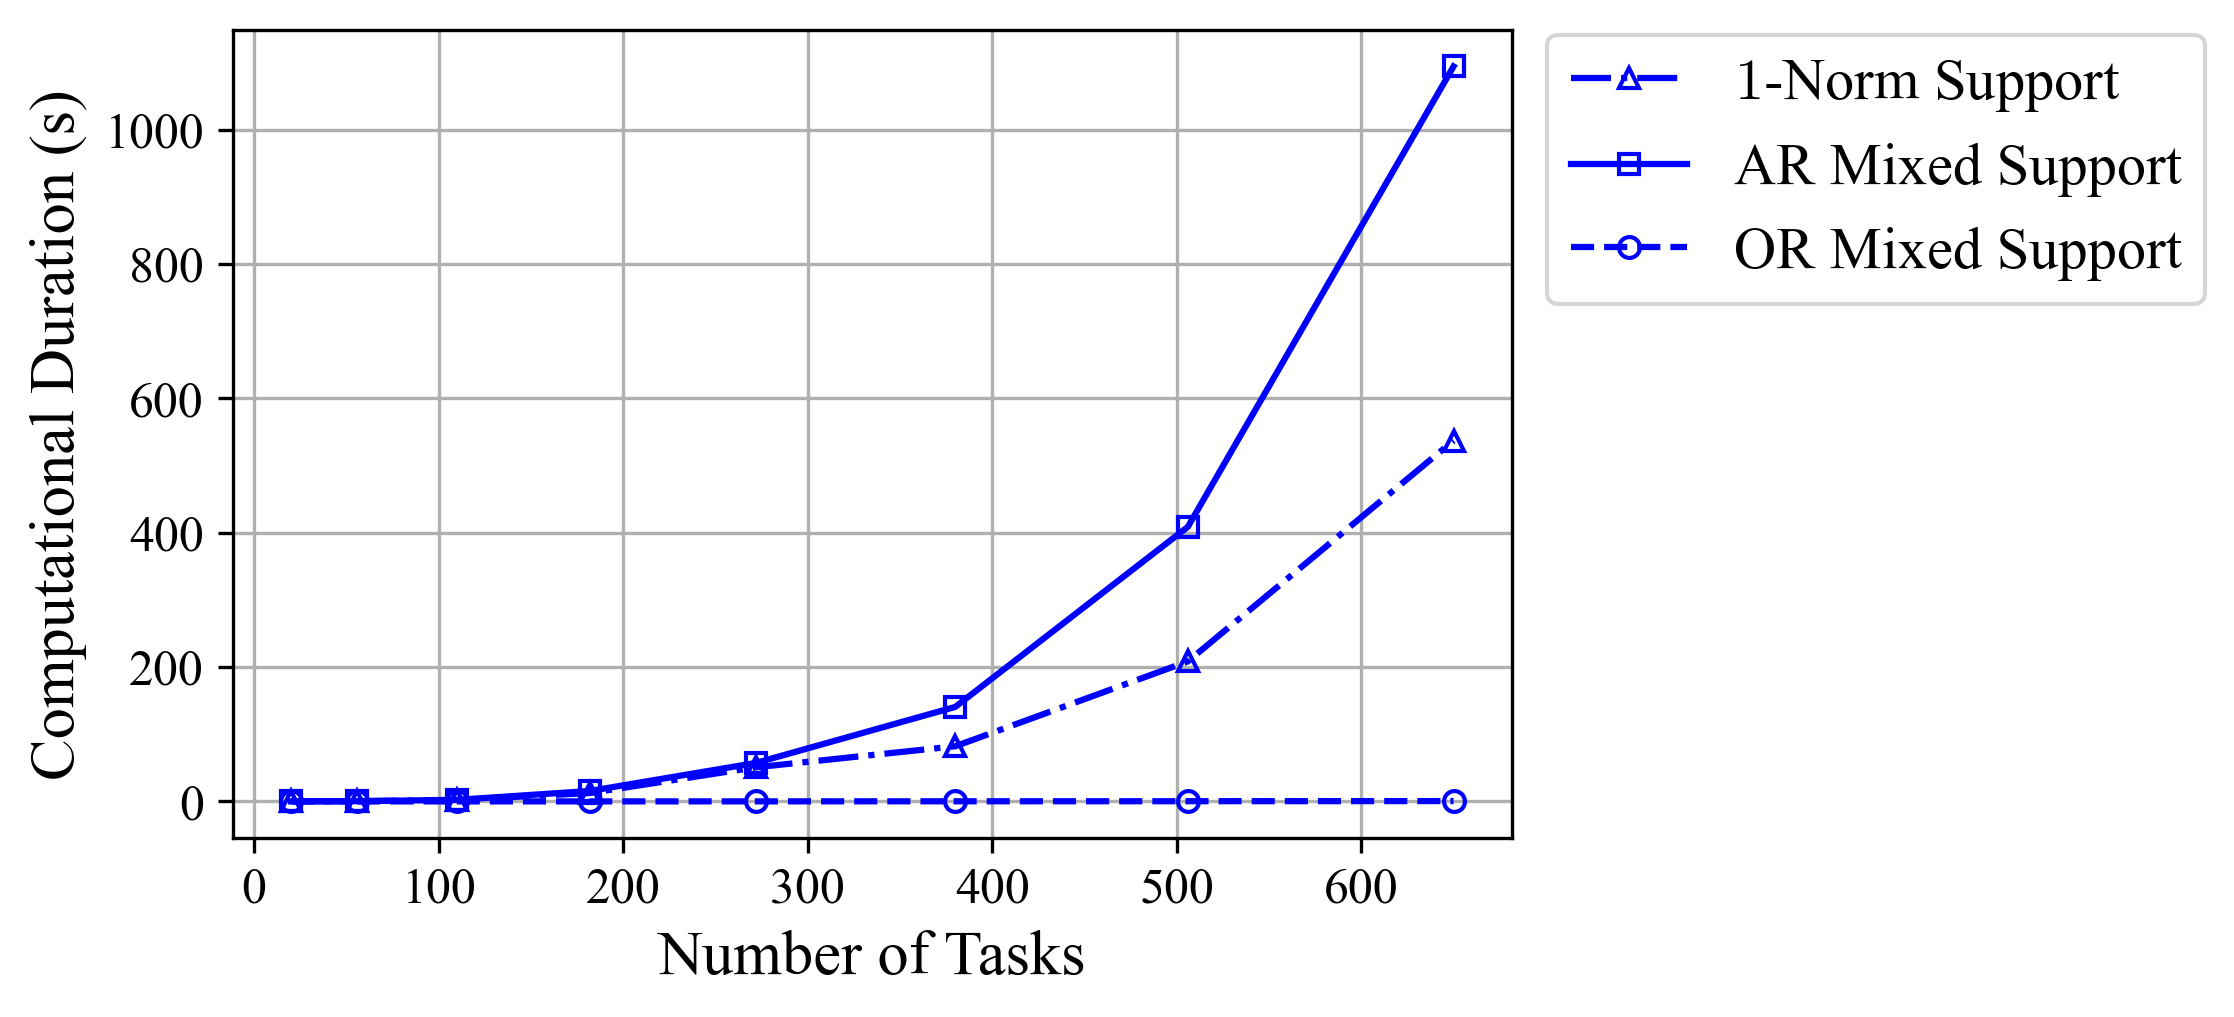

In [10]:
import matplotlib.pyplot as plt
nn = 8
step = 3
dims = [(4+step*i) * (5+step*i) for i in range(nn)]

plt.figure(figsize=(5.5, 3.5), dpi=300)
plt.plot(dims, rs_delta_time, 
         marker='^', markersize=5, color='b', markerfacecolor='none', linestyle='-.',
         label=r'$1$-Norm Support')
plt.plot(dims, rs_box_time, 
         marker='s', markersize=5, color='b', markerfacecolor='none', 
         label='AR Mixed Support')
plt.plot(dims, rs_ic_time, 
         marker='o', markersize=5, color='b', markerfacecolor='none', linestyle='--',
         label='OR Mixed Support')

plt.grid()
plt.legend(bbox_to_anchor=(1.005, 1.03), fontsize=fl)
plt.xticks(fontsize=ft)
plt.yticks(fontsize=ft)
plt.xlabel('Number of Tasks', fontsize=fs)
plt.ylabel('Computational Duration (s)', fontsize=fs)
plt.show()

In [11]:
pd.DataFrame({'One-Norm Support': rs_delta_time,
              'OR Mixed Support': rs_ic_time,
              'AR Mixed Support': rs_box_time}).T

,0,1,2,3,4,5,6,7
One-Norm Support,0.013197,0.379135,2.274072,12.510552,50.789681,82.102476,208.361378,537.091507
OR Mixed Support,0.000846,0.003872,0.012829,0.029533,0.073732,0.181567,0.287467,0.516131
AR Mixed Support,0.037275,0.404730,2.346692,15.587305,57.339124,140.710016,408.610229,1093.911771
